In [42]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable 

In [43]:
class Encoder(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Encoder,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
    def forward(self,x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [44]:
class Decoder(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Decoder,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
    def forward(self,x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [47]:
class VAE(nn.Module):
    def __init__(self,encoder,decoder):
        super(VAE,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = nn.Linear(100,8)
        self._enc_log_sigma = nn.Linear(100,8)
        
    def _sample_latent(self,h_enc):
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0,1,size = sigma.size())).float()
        
        self.z_mean = mu
        self.z_sigma = sigma
        
        return mu + sigma * Variable(std_z,requires_grad = False)
    
    def forward(self,state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        output = self.decoder(z)
        return output

NUM_SAMPLES: 60000


/Users/caijie/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/Users/caijie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch: 0, loss: 0.066152
epoch: 1, loss: 0.065962
epoch: 2, loss: 0.064354
epoch: 3, loss: 0.066917
epoch: 4, loss: 0.073372
epoch: 5, loss: 0.069688
epoch: 6, loss: 0.061277
epoch: 7, loss: 0.071178
epoch: 8, loss: 0.068341
epoch: 9, loss: 0.063634
epoch: 10, loss: 0.075112
epoch: 11, loss: 0.070322
epoch: 12, loss: 0.068794
epoch: 13, loss: 0.067258
epoch: 14, loss: 0.064795
epoch: 15, loss: 0.069586
epoch: 16, loss: 0.070698
epoch: 17, loss: 0.061841
epoch: 18, loss: 0.072216
epoch: 19, loss: 0.069646
epoch: 20, loss: 0.063879
epoch: 21, loss: 0.064958
epoch: 22, loss: 0.065745
epoch: 23, loss: 0.062291
epoch: 24, loss: 0.065736
epoch: 25, loss: 0.067382
epoch: 26, loss: 0.068734
epoch: 27, loss: 0.065126
epoch: 28, loss: 0.066158
epoch: 29, loss: 0.072401
epoch: 30, loss: 0.065767
epoch: 31, loss: 0.062006
epoch: 32, loss: 0.069818
epoch: 33, loss: 0.066680
epoch: 34, loss: 0.064282
epoch: 35, loss: 0.070074
epoch: 36, loss: 0.071773
epoch: 37, loss: 0.071648
epoch: 38, loss: 0.068

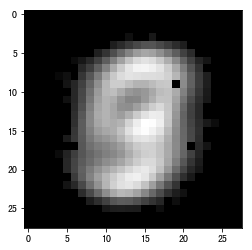

In [48]:
def latent_loss(mean,std):
    mean_sq = mean*mean
    std_sq = std*std
    return 0.5 * torch.mean(mean_sq + std_sq - torch.log(std_sq) - 1)
    
if __name__=='__main__':
    batch_size = 32
    input_size = 28*28
    transform = transforms.Compose([transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./',download=True,transform=transform)
    dataloader = torch.utils.data.DataLoader(mnist,batch_size = batch_size,shuffle = True,num_workers = 2)
    print('NUM_SAMPLES:',len(mnist))
    
    encoder = Encoder(input_size,100,100)
    decoder = Decoder(8,100,input_size)
    vae = VAE(encoder,decoder)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(vae.parameters(),lr = 0.001)
    l = None
    
    for epoch in range(100):
        for i,data in enumerate(dataloader,0):
            inputs,classes = data
            inputs,classes = Variable(inputs.resize(batch_size,input_size)),Variable(classes)
            dec = vae(inputs)
            optimizer.zero_grad()
            ll = latent_loss(vae.z_mean,vae.z_sigma)
            loss = criterion(dec,inputs)+ll
            loss.backward()
            optimizer.step()
            l = loss.data[0]
        print('epoch: %d, loss: %f' % (epoch,l))
        
    plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)